# NLP Coursework


## English-German

### Importing Data

In [1]:
# Download and unzip the data
from os.path import exists
if not exists('ende_data.zip'):
    !wget -O ende_data.zip https://competitions.codalab.org/my/datasets/download/c748d2c0-d6be-4e36-9f12-ca0e88819c4d
    !unzip ende_data.zip
!pip install bert-for-tf2
!pip install sentencepiece
!pip install transformers

In [2]:
# Check the files
import io
#English-German
print("---EN-DE---")
print()

with open("./train.ende.src", encoding="utf8") as ende_src:
  print("Source: ", ende_src.readline())
with open("./train.ende.mt", encoding="utf8") as ende_mt:
  print("Translation: ", ende_mt.readline())
with open("./train.ende.scores", encoding="utf8") as ende_scores:
  print("Score: ", ende_scores.readline())


---EN-DE---

Source:  José Ortega y Gasset visited Husserl at Freiburg in 1934.

Translation:  1934 besuchte José Ortega y Gasset Husserl in Freiburg.

Score:  1.1016968715664406



### Computing Sentence Embeddings 

For this baseline model, we will simply use pre-trained GloVe embeddings via the Spacy module and compute the vector for each word and take the global mean for each sentence. We will do the same for both source and translation sentences. 

This is a very simplistic approach so feel free to be more creative and play around with how the sentence embeddings are computed for example ;).

In [4]:
#Downloading spacy models for english and german

!spacy download en_core_web_md
!spacy link en_core_web_md en300

!spacy download de_core_news_md
!spacy link de_core_news_md de300

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')

✘ Link 'en300' already exists
To overwrite an existing link, use the --force flag

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_md')

✘ Link 'de300' already exists
To overwrite an existing link, use the --force flag



We can now write our functions that will return the average embeddings for a sentence.

#### Pre-processing with Spacy


In [5]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
    
import spacy
from nltk.corpus import stopwords
from nltk import download

nlp_de = spacy.load('de300')
nlp_en = spacy.load('en300')

#downloading stopwords from the nltk package
download('stopwords') #stopwords dictionary, run once

stop_words_en = set(stopwords.words('english'))
stop_words_de = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/group-59/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import matplotlib.pyplot as plt

file_de = open("./train.ende.src") 
file_en = open("./train.ende.mt") 

lines_de = file_de.readlines() 
lines_en = file_en.readlines() 

max_length = 0
lengths_de = []
lengths_en = []

for i in range(len(lines_de)):
    text_de = lines_en[i].lower()
    text_en = lines_de[i].lower()

    l = [token.lemma_ for token in nlp_en.tokenizer(text_en)]
    #l = [word for word in l if word not in stop_words_en.union(set(["\n", ".", ","]))]
    l = [word for word in l if word not in stop_words_en]
    lengths_en.append(len(l))
    if len(l) > max_length: 
        max_length = len(l)
        
    l = [token.lemma_ for token in nlp_de.tokenizer(text_de)]
    #l = [word for word in l if word not in stop_words_de.union(set(["\n", ".", ","]))]
    l = [word for word in l if word not in stop_words_de]
    lengths_de.append(len(l))
    if len(l) > max_length: 
        max_length = len(l)
    
print(max_length)

# plt.figure()
# plt.hist(lengths_en, bins=28)

# plt.figure()
# plt.hist(lengths_de, bins=31)

# plt.show()

32


#### Preprocessing with Bert Tokenizer

In [7]:
import numpy as np
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

## Tokenize each sentences with Bert and adding the tags [CLS] and [SEP] to demarcate sentences
def get_sentence_emb(line, nlp, lang):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize('[CLS] '+line+' [SEP]')) 


def get_embeddings(f,nlp,lang):
    file = open(f) 
    lines = file.readlines()
    sentences_vectors =[]

    for l in lines:
        vec = get_sentence_emb(l,nlp,lang)

        if vec is not None:
            sentences_vectors.append(vec)
        else:
            print("didn't work :", l)
            sentences_vectors.append(0)

    return sentences_vectors

#### Getting Training and Validation Sets

We will now run the code fo the English-German translations and getting our training and validation sets ready for the regression task.


In [8]:
## define our device, if possible cuda
import torch
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# EN-DE files
de_train_src = get_embeddings("./train.ende.src",nlp_en,'en')
de_train_mt = get_embeddings("./train.ende.mt",nlp_de,'de')

f_train_scores = open("./train.ende.scores",'r')
de_train_scores = f_train_scores.readlines()

de_val_src = get_embeddings("./dev.ende.src",nlp_en,'en')
de_val_mt = get_embeddings("./dev.ende.mt",nlp_de,'de')
f_val_scores = open("./dev.ende.scores",'r')
de_val_scores = f_val_scores.readlines()

cuda:0


In [9]:
# Verify the preprocessing
print(f"Training mt: {len(de_train_mt)} Training src: {len(de_train_src)}")
print(f"Validation mt: {len(de_val_mt)} Validation src: {len(de_val_src)}")

Training mt: 7000 Training src: 7000
Validation mt: 1000 Validation src: 1000


### Prepare Data for Bert classifier


#### Transform sentences and score

In [11]:
# Transformation into Torch tensor

from keras.preprocessing.sequence import pad_sequences

#regroup german and english sentences together
import random 
X_train_en = de_train_src
X_train_de = de_train_mt
X_train = []

for i in range(len(X_train_en)):
    X_train.append(X_train_en[i]+X_train_de[i])

X_train[0]
    
X_val_en = de_val_src
X_val_de = de_val_mt
X_val = []

for i in range(len(X_val_en)):
    X_val.append(X_val_en[i]+X_val_de[i])

# use padding for our regroup sentences 

max_train=max([len(sen) for sen in X_train])
input_ids = pad_sequences(X_train, maxlen=max_train, dtype="long", 
                          value=0, truncating="post", padding="post")
val_ids = pad_sequences(X_val, maxlen=max_train, dtype="long", 
                          value=0, truncating="post", padding="post")

# transform sentences into tensor
train_inputs = torch.tensor(input_ids)
validation_inputs = torch.tensor(val_ids)


# normalized labels and create tensor
train_scores = np.array(de_train_scores).astype(float)
val_scores = np.array(de_val_scores).astype(float)
min_t =np.amin( train_scores)
max_t = np.amax( train_scores)

train_labels = torch.tensor(train_scores).float()
validation_labels = torch.tensor(val_scores).float()
train_labels=(train_labels - min_t)/(max_t-min_t)
validation_labels=(validation_labels - min_t)/(max_t-min_t)


Using TensorFlow backend.


#### Create mask for training

In [12]:
# Create attention masks
train_masks = []

# For each sentence of training set
for sent in input_ids:
    
    # Create the attention mask.
    #   Set the mask to 1
    att_mask = [int(token_id > 0) for token_id in sent]
                
    
    # Store the attention mask for this sentence.
    train_masks.append(att_mask)

validation_masks = []

# For each sentence of test set
for sent in val_ids:
    
    # Create the attention mask.
    #  set the mask to 1
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    validation_masks.append(att_mask)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Bert

### Install model

In [15]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# matplotlib inline


In [16]:
# Select a batch size for training. 
batch_size = 50

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [22]:
#define model
import torch.nn as nn
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

### Train Model

In [53]:
bert_clf = BertBinaryClassifier()

In [56]:
from keras import optimizers
EPOCHS = 3
train_loss=0
train_loss_curve=[]
test_loss=0
test_loss_curve=[]
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)
bert_clf.train()

#Train our model and print result at each epoch
for epoch_num in range(EPOCHS):
    print("\n======================================================")
    print('Epoch: ', epoch_num + 1)
    print("======================================================\n")
    bert_clf.train()
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        probas = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        print(probas.view(-1))
        print(labels)
        print()
        batch_loss = loss_func(probas.view(-1), labels)
        train_loss += batch_loss.item()
        train_loss_curve.append(train_loss / (step_num + 1))
        bert_clf.zero_grad()
        batch_loss.backward()
        optimizer.step()
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / batch_size, train_loss / (step_num + 1)))
    # test at each epoch 
    bert_clf.eval()
    with torch.no_grad():
        for step_num, batch_data in enumerate(validation_dataloader):
            token_ids, masks, labels = tuple(t for t in batch_data)
            logits = bert_clf(token_ids, masks)
            loss_func = nn.BCELoss()
            batch_loss = loss_func(probas.view(-1), labels)
            test_loss += batch_loss.item()
            test_loss_curve.append(test_loss / (step_num + 1))




Epoch:  1

tensor([0.7045, 0.7602, 0.7792, 0.7589, 0.7353, 0.7326, 0.7798, 0.7322, 0.7030,
        0.7280, 0.7466, 0.7559, 0.7432, 0.7716, 0.7497, 0.7015, 0.7630, 0.7996,
        0.7434, 0.7848, 0.7262, 0.7279, 0.7899, 0.7052, 0.7394, 0.7534, 0.6954,
        0.7851, 0.7634, 0.6853, 0.7711, 0.7725, 0.7316, 0.7331, 0.6764, 0.7748,
        0.7449, 0.7418, 0.7578, 0.7718, 0.8075, 0.7934, 0.7971, 0.7080, 0.7935,
        0.7485, 0.7934, 0.7536, 0.7694, 0.7372], grad_fn=<ViewBackward>)
tensor([0.7885, 0.7716, 0.7502, 0.7410, 0.7445, 0.5946, 0.7078, 0.7857, 0.7601,
        0.7343, 0.7701, 0.7054, 0.7376, 0.7748, 0.7449, 0.7154, 0.7514, 0.7514,
        0.7623, 0.7450, 0.6558, 0.7983, 0.7779, 0.6974, 0.8266, 0.7364, 0.7547,
        0.7872, 0.7383, 0.7492, 0.7721, 0.7616, 0.5043, 0.7364, 0.7767, 0.7579,
        0.7092, 0.7860, 0.6155, 0.7780, 0.7296, 0.8204, 0.8002, 0.7852, 0.7793,
        0.6415, 0.8038, 0.7296, 0.7373, 0.7424])

0/140.0 loss: 0.5715100765228271 
tensor([0.7588, 0.7195, 0.7288,

8/140.0 loss: 0.5686462918917338 


KeyboardInterrupt: 

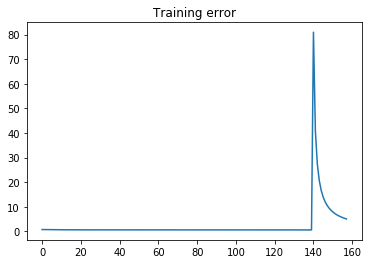

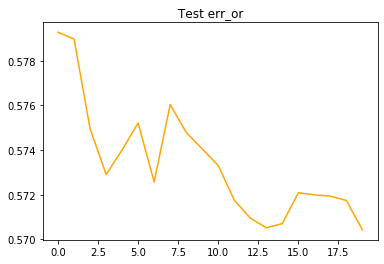

In [55]:
plt.figure()
plt.plot(train_loss_curve)
plt.title("Training error")
plt.figure()
plt.plot(test_loss_curve, color='orange')
plt.title("Test err_or")
plt.show()

In [57]:
bert_clf = torch.load("bert-1-epoch.pth")

### Test Model

In [58]:
#get prediction for test set
bert_clf.eval()
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(validation_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        all_logits += list(numpy_logits[:, 0])
        print('One')        
print(all_logits)

One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
[0.7686386, 0.7642594, 0.76705843, 0.77130836, 0.76574004, 0.76259714, 0.7608875, 0.76757175, 0.7643948, 0.76353705, 0.77080905, 0.7711928, 0.76398325, 0.76731104, 0.7639812, 0.77033734, 0.76824296, 0.76552063, 0.7680111, 0.768026, 0.76854986, 0.76210946, 0.7692506, 0.77017605, 0.769563, 0.76582456, 0.76697254, 0.7685399, 0.7667852, 0.7672276, 0.7653242, 0.76853013, 0.769239, 0.7652554, 0.7650749, 0.76666707, 0.7674311, 0.76113105, 0.7640891, 0.7658187, 0.76836723, 0.7684849, 0.7690999, 0.76755255, 0.7693482, 0.7614947, 0.7652667, 0.76913077, 0.764423, 0.7634952, 0.7685646, 0.7644568, 0.7646172, 0.76868004, 0.771374, 0.7663773, 0.7658981, 0.76408666, 0.7672378, 0.7693468, 0.7666945, 0.76679707, 0.7632659, 0.7644874, 0.76318073, 0.7644417, 0.76870894, 0.767874, 0.76206726, 0.7691766, 0.7660236, 0.7637485, 0.7680888, 0.77171934, 0.7676098, 0.7652823, 0.76742876, 0.7640579, 0.77030027, 0.76437795, 0.7681531, 0

0.7686386
0.2415179820904676
0.7642594
0.19376137136707072
0.76705843
0.22428566584476606
0.77130836
0.270632412966755
0.76574004
0.20990817714050358
0.76259714
0.17563399648645017
0.7608875
0.1569898666205276
0.76757175
0.22988351984906608
0.7643948
0.19523818561437345
0.76353705
0.18588394537100683
0.77080905
0.26518731043609733
0.7711928
0.26937205080763427
0.76398325
0.19074989231436312
0.76731104
0.22704039242050023
0.7639812
0.1907277921011552
0.77033734
0.2600431608088307
0.76824296
0.23720324046476549
0.76552063
0.20751550405761598
0.7680111
0.234674716071277
0.768026
0.23483721763898302
0.76854986
0.2405501227532163
0.76210946
0.17031564517860254
0.7692506
0.2481915964729744
0.77017605
0.2582842438399915
0.769563
0.2515989293446115
0.76582456
0.21082988603252595
0.76697254
0.22334900680851533
0.7685399
0.2404415717059898
0.7667852
0.22130603709932828
0.7672276
0.22613038364135285
0.7653242
0.20537308338899507
0.76853013
0.24033497067757637
0.769239
0.2480654952564354
0.7652554

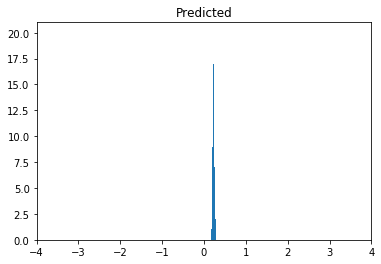

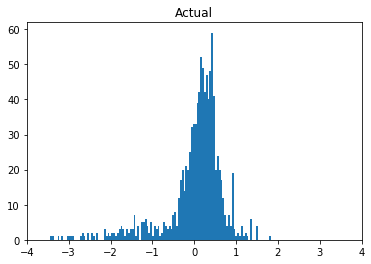

In [69]:
# Evaluation on test set
outputs = []

with torch.no_grad():
    prediction = []
    true_score = []
    
    for i in range(len(X_val)):
        prediction.append((all_logits[i]*(max_t-min_t))+min_t)
        true_score.append(val_scores[i].item())

from scipy.stats.stats import pearsonr
pearson = pearsonr(true_score, prediction)
print(pearson[0])

plt.figure()
axes = plt.gca()
axes.set_xlim([-4,4])
plt.hist(prediction, bins=200)
plt.title("Predicted")

plt.figure()
axes = plt.gca()
axes.set_xlim([-4,4])
plt.hist(true_score, bins=200)
plt.title("Actual")

plt.show()

### Prediction of unknow dataset

In [38]:
#import set
de_testf_src = get_embeddings("./test.ende.src",nlp_en,'en')
de_testf_mt = get_embeddings("./test.ende.mt",nlp_de,'de')
print(f"Training mt: {len(de_testf_mt)} Training src: {len(de_testf_src)}")

Training mt: 1000 Training src: 1000


In [39]:
#preprocess set
X_testf_en = de_testf_src
X_testf_de = de_testf_mt
X_testf = []

for i in range(len(X_testf_en)):
    X_testf.append(X_testf_en[i]+X_testf_de[i])

X_testf[0]
    
testf_ids = pad_sequences(X_testf, maxlen=max_train, dtype="long", 
                          value=0, truncating="post", padding="post")
# Scores
testf_inputs = torch.tensor(testf_ids)

In [40]:
#create corresponding mask
testf_masks = []

# For each sentence...
for sent in testf_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1
    att_mask = [int(token_id > 0) for token_id in sent]
                
    
    # Store the attention mask for this sentence.
    testf_masks.append(att_mask)
testf_masks = torch.tensor(testf_masks)


In [41]:
# Create batch
testf_data = TensorDataset(testf_inputs, testf_masks, validation_labels)
testf_sampler = SequentialSampler(testf_data)
testf_dataloader = DataLoader(testf_data, sampler=validation_sampler, batch_size=batch_size)

In [42]:
#predict results
bert_clf.eval()
allf_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(testf_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        allf_logits += list(numpy_logits[:, 0])
        print('One')        
print(allf_logits)

One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
One
[0.7709172, 0.7688301, 0.76549625, 0.76826584, 0.7640199, 0.7680972, 0.76828545, 0.7674191, 0.76349896, 0.7677786, 0.7666277, 0.76734495, 0.7673382, 0.7659352, 0.76668626, 0.76307607, 0.76500905, 0.76411897, 0.7630839, 0.76648223, 0.76448053, 0.75721085, 0.7663126, 0.7676438, 0.7656683, 0.7662965, 0.76507336, 0.7653925, 0.7694168, 0.76666844, 0.76423883, 0.7664289, 0.7670185, 0.767317, 0.76740146, 0.7674211, 0.76852185, 0.76467544, 0.7686099, 0.76764905, 0.76693994, 0.76742584, 0.77140784, 0.77029145, 0.76643294, 0.7622806, 0.76577353, 0.7662801, 0.76609194, 0.7656719, 0.76574486, 0.7686186, 0.76894236, 0.77120507, 0.76682204, 0.77195406, 0.77188724, 0.7644618, 0.77236205, 0.7678551, 0.76808375, 0.76542, 0.7629479, 0.7638355, 0.7640579, 0.76932, 0.77012765, 0.76303893, 0.76694393, 0.7674215, 0.7693637, 0.7644453, 0.7683847, 0.7670948, 0.76917464, 0.77048165, 0.7643614, 0.7678806, 0.76814, 0.7665214, 0.76723

Text(0.5, 1.0, 'Predicted')

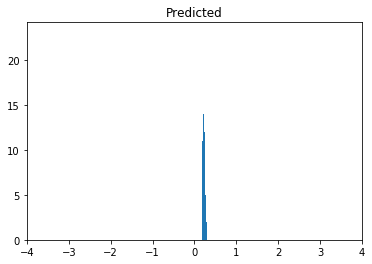

In [43]:
#display results
with torch.no_grad():
    predictionf = []
    
    for i in range(len(X_val)):
        predictionf.append((allf_logits[i]*(max_t-min_t))+min_t)

plt.figure()
axes = plt.gca()
axes.set_xlim([-4,4])
plt.hist(predictionf, bins=200)
plt.title("Predicted")

In [44]:
# save predictions

with open('predictions.txt', 'w') as f:
    for item in predictionf:
        f.write("%s\n" % item)